In [1]:
# import
import os, sys, shutil, pickle
import numpy as np
import pandas as pd
import scipy as sp
import nibabel as nib
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
from snaplab_tools.utils import threshold_consistency, normalize_x
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns

## Load data

In [2]:
in_dir = '/mnt/storage_ssd_raid/research_data/HCP_D/collated_outputs'

atlas = 'Schaefer4007'
if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100

### Connectome

In [3]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpd_connectome.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['sub-HCD0001305V1MR', 'sub-HCD0008117V1MR', 'sub-HCD0021614V1MR', 'sub-HCD0022919V1MR', 'sub-HCD0026119V1MR', 'sub-HCD0029630V1MR', 'sub-HCD0031617V1MR', 'sub-HCD0040113V1MR', 'sub-HCD0041822V1MR', 'sub-HCD0042420V1MR', 'sub-HCD0051825V1MR', 'sub-HCD0059235V1MR', 'sub-HCD0069238V1MR', 'sub-HCD0071831V1MR', 'sub-HCD0075435V1MR', 'sub-HCD0110310V1MR', 'sub-HCD0110411V1MR', 'sub-HCD0111716V1MR', 'sub-HCD0114419V1MR', 'sub-HCD0118528V1MR', 'sub-HCD0119429V1MR', 'sub-HCD0121719V1MR', 'sub-HCD0123925V1MR', 'sub-HCD0124725V1MR', 'sub-HCD0125424V1MR', 'sub-HCD0128935V1MR', 'sub-HCD0129937V1MR', 'sub-HCD0130821V1MR', 'sub-HCD0134526V1MR', 'sub-HCD0135831V1MR', 'sub-HCD0143426V1MR', 'sub-HCD0145733V1MR', 'sub-HCD0146331V1MR', 'sub-HCD0146937V1MR', 'sub-HCD0147333V1MR', 'sub-HCD0152932V1MR', 'sub-HCD0154431V1MR', 'sub-HCD0161327V1MR', 'sub-HCD0174235V1MR', 'sub-HCD0182941V1MR', 'sub-HCD0183438V1MR', 'sub-HCD0183539V1MR', 'sub-HCD0185442V1MR', 'sub-HCD0185644V1MR', 'sub-HCD0193845V1MR',

In [4]:
subject_ids = list(data.keys())
n_subs = len(subject_ids)
n_subs

652

In [5]:
subject_filter = np.zeros(n_subs).astype(bool)

In [6]:
parc_dir = '/mnt/storage_ssd_raid/research_data/HCP_D/derivatives/parcellations'

A = np.zeros((n_parcels, n_parcels, n_subs))

for i in np.arange(n_subs):
    try:
        adj = data[subject_ids[i]]['ses-01PA'][atlas].copy()
        
        in_file = os.path.join(parc_dir, '{0}/ses-01/{0}_ses-01_atlas-{1}_space-T1w_res-1_regionsizes.txt'.format(subject_ids[i], atlas))
        voxel_counts = np.loadtxt(in_file, dtype=int)
        voxel_counts = normalize_x(voxel_counts) + 1e-5
        size_matrix = np.add.outer(voxel_counts, voxel_counts) / 2
        adj = np.divide(adj, size_matrix)
        adj_mask = adj > 0
        adj[adj_mask] += 1
        adj = np.log(adj, out=np.zeros_like(adj), where=(adj != 0))

        A[:, :, i] = adj
    except:
        subject_filter[i] = True
        
print(np.sum(subject_filter))

17


In [7]:
print(np.any(A < 0))
print(np.any(np.isinf(A)))
print(np.any(np.isnan(A)))

False
False
False


### rest fmri

In [8]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpd_rsfmri.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['sub-HCD0001305V1MR', 'sub-HCD0008117V1MR', 'sub-HCD0021614V1MR', 'sub-HCD0022919V1MR', 'sub-HCD0026119V1MR', 'sub-HCD0029630V1MR', 'sub-HCD0031617V1MR', 'sub-HCD0040113V1MR', 'sub-HCD0041822V1MR', 'sub-HCD0042420V1MR', 'sub-HCD0051825V1MR', 'sub-HCD0059235V1MR', 'sub-HCD0069238V1MR', 'sub-HCD0071831V1MR', 'sub-HCD0075435V1MR', 'sub-HCD0110310V1MR', 'sub-HCD0110411V1MR', 'sub-HCD0111716V1MR', 'sub-HCD0114419V1MR', 'sub-HCD0118528V1MR', 'sub-HCD0119429V1MR', 'sub-HCD0121719V1MR', 'sub-HCD0123925V1MR', 'sub-HCD0124725V1MR', 'sub-HCD0125424V1MR', 'sub-HCD0128935V1MR', 'sub-HCD0129937V1MR', 'sub-HCD0130821V1MR', 'sub-HCD0134526V1MR', 'sub-HCD0135831V1MR', 'sub-HCD0143426V1MR', 'sub-HCD0145733V1MR', 'sub-HCD0146331V1MR', 'sub-HCD0146937V1MR', 'sub-HCD0147333V1MR', 'sub-HCD0152932V1MR', 'sub-HCD0154431V1MR', 'sub-HCD0161327V1MR', 'sub-HCD0174235V1MR', 'sub-HCD0182941V1MR', 'sub-HCD0183438V1MR', 'sub-HCD0183539V1MR', 'sub-HCD0185442V1MR', 'sub-HCD0185644V1MR', 'sub-HCD0193845V1MR',

In [9]:
scans = [
    'rfMRIREST1AP',
    'rfMRIREST1PA',
    'rfMRIREST2AP',
    'rfMRIREST2PA'
    ]

In [10]:
rsts = np.zeros((478, n_parcels, len(scans), n_subs))

for s, scan in enumerate(scans):
    print(scan)
    for i in tqdm(np.arange(n_subs)):
        try:
            ts = data[subject_ids[i]]['ses-01'][atlas][scan].copy()
            
            gs = np.mean(ts, axis=1).reshape(-1, 1)
            gs_diff = np.append(0, np.diff(gs, axis=0)).reshape(-1, 1)
            nuis = np.concatenate((gs, gs_diff), axis=1)
            nuis = np.concatenate((nuis, np.square(nuis)), axis=1)

            regr = LinearRegression()
            regr.fit(nuis, ts)
            y_pred = regr.predict(nuis)
            ts = ts - y_pred
            
            # z score
            ts = sp.stats.zscore(ts, axis=0)
            
            if np.any(np.isnan(ts)):
                print('Found NaNs!')
            if np.any(np.isinf(ts)):
                print('Found infs!')

            rsts[:, :, s, i] = ts
        except:
            subject_filter[i] = True
    print(np.sum(subject_filter))
    
print(np.sum(subject_filter))

rfMRIREST1AP


100%|██████████| 652/652 [00:04<00:00, 142.04it/s]


35
rfMRIREST1PA


100%|██████████| 652/652 [00:04<00:00, 150.16it/s]


36
rfMRIREST2AP


100%|██████████| 652/652 [00:04<00:00, 139.09it/s]


36
rfMRIREST2PA


100%|██████████| 652/652 [00:04<00:00, 157.61it/s]

36
36


### task fmri

In [11]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpd_tfmri.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['sub-HCD0001305V1MR', 'sub-HCD0008117V1MR', 'sub-HCD0021614V1MR', 'sub-HCD0022919V1MR', 'sub-HCD0026119V1MR', 'sub-HCD0029630V1MR', 'sub-HCD0031617V1MR', 'sub-HCD0040113V1MR', 'sub-HCD0041822V1MR', 'sub-HCD0042420V1MR', 'sub-HCD0051825V1MR', 'sub-HCD0059235V1MR', 'sub-HCD0069238V1MR', 'sub-HCD0071831V1MR', 'sub-HCD0075435V1MR', 'sub-HCD0110310V1MR', 'sub-HCD0110411V1MR', 'sub-HCD0111716V1MR', 'sub-HCD0114419V1MR', 'sub-HCD0118528V1MR', 'sub-HCD0119429V1MR', 'sub-HCD0121719V1MR', 'sub-HCD0123925V1MR', 'sub-HCD0124725V1MR', 'sub-HCD0125424V1MR', 'sub-HCD0128935V1MR', 'sub-HCD0129937V1MR', 'sub-HCD0130821V1MR', 'sub-HCD0134526V1MR', 'sub-HCD0135831V1MR', 'sub-HCD0143426V1MR', 'sub-HCD0145733V1MR', 'sub-HCD0146331V1MR', 'sub-HCD0146937V1MR', 'sub-HCD0147333V1MR', 'sub-HCD0152932V1MR', 'sub-HCD0154431V1MR', 'sub-HCD0161327V1MR', 'sub-HCD0174235V1MR', 'sub-HCD0182941V1MR', 'sub-HCD0183438V1MR', 'sub-HCD0183539V1MR', 'sub-HCD0185442V1MR', 'sub-HCD0185644V1MR', 'sub-HCD0193845V1MR',

In [12]:
scans = [
    'tfMRICARITPA',
    'tfMRIEMOTIONPA',
    'tfMRIGUESSINGPA',
    'tfMRICARITAP',
    'tfMRIGUESSINGAP'
    ]
taskts_dict = dict()

In [13]:
taskts = np.zeros((1, n_parcels, n_subs))

for scan in scans:
    n_trs_task = data[subject_ids[0]]['ses-01'][atlas][scan].shape[0]
    print(scan, n_trs_task)
    taskts_tmp = np.zeros((n_trs_task, n_parcels, n_subs))
    for i in tqdm(np.arange(n_subs)):
        try:
            ts = data[subject_ids[i]]['ses-01'][atlas][scan].copy()
            
            gs = np.mean(ts, axis=1).reshape(-1, 1)
            gs_diff = np.append(0, np.diff(gs, axis=0)).reshape(-1, 1)
            nuis = np.concatenate((gs, gs_diff), axis=1)
            nuis = np.concatenate((nuis, np.square(nuis)), axis=1)

            regr = LinearRegression()
            regr.fit(nuis, ts)
            y_pred = regr.predict(nuis)
            ts = ts - y_pred
            
            # z score
            ts = sp.stats.zscore(ts, axis=0)
            
            if np.any(np.isnan(ts)):
                print('Found NaNs!')
            if np.any(np.isinf(ts)):
                print('Found infs!')

            taskts_tmp[:, :, i] = ts
        except:
            subject_filter[i] = True
    
    taskts = np.concatenate((taskts, taskts_tmp.copy()), axis=0)
    taskts_dict[scan] = taskts_tmp.copy()
    
taskts = taskts[1:]

print(np.sum(subject_filter))

tfMRICARITPA 290


100%|██████████| 652/652 [00:02<00:00, 246.70it/s]


tfMRIEMOTIONPA 168


100%|██████████| 652/652 [00:01<00:00, 394.88it/s]


tfMRIGUESSINGPA 270


100%|██████████| 652/652 [00:02<00:00, 263.84it/s]


tfMRICARITAP 290


100%|██████████| 652/652 [00:02<00:00, 238.56it/s]


tfMRIGUESSINGAP 270


100%|██████████| 652/652 [00:02<00:00, 272.43it/s]


47


### myelin

In [14]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpd_myelin.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['sub-HCD0001305V1MR', 'sub-HCD0008117V1MR', 'sub-HCD0021614V1MR', 'sub-HCD0022919V1MR', 'sub-HCD0026119V1MR', 'sub-HCD0029630V1MR', 'sub-HCD0031617V1MR', 'sub-HCD0040113V1MR', 'sub-HCD0041822V1MR', 'sub-HCD0042420V1MR', 'sub-HCD0051825V1MR', 'sub-HCD0059235V1MR', 'sub-HCD0069238V1MR', 'sub-HCD0071831V1MR', 'sub-HCD0075435V1MR', 'sub-HCD0110310V1MR', 'sub-HCD0110411V1MR', 'sub-HCD0111716V1MR', 'sub-HCD0114419V1MR', 'sub-HCD0118528V1MR', 'sub-HCD0119429V1MR', 'sub-HCD0121719V1MR', 'sub-HCD0123925V1MR', 'sub-HCD0124725V1MR', 'sub-HCD0125424V1MR', 'sub-HCD0128935V1MR', 'sub-HCD0129937V1MR', 'sub-HCD0130821V1MR', 'sub-HCD0134526V1MR', 'sub-HCD0135831V1MR', 'sub-HCD0143426V1MR', 'sub-HCD0145733V1MR', 'sub-HCD0146331V1MR', 'sub-HCD0146937V1MR', 'sub-HCD0147333V1MR', 'sub-HCD0152932V1MR', 'sub-HCD0154431V1MR', 'sub-HCD0161327V1MR', 'sub-HCD0174235V1MR', 'sub-HCD0182941V1MR', 'sub-HCD0183438V1MR', 'sub-HCD0183539V1MR', 'sub-HCD0185442V1MR', 'sub-HCD0185644V1MR', 'sub-HCD0193845V1MR',

In [15]:
myelin = np.zeros((n_parcels, n_subs))

for i in np.arange(n_subs):
    try:
        myelin[:, i] = data[subject_ids[i]]['ses-01'][atlas]
    except:
        subject_filter[i] = True
        
print(np.sum(subject_filter))

47


## Filter

In [16]:
np.asarray(subject_ids)[subject_filter]

array(['sub-HCD0161327V1MR', 'sub-HCD0295954V1MR', 'sub-HCD0403224V1MR',
       'sub-HCD0494354V1MR', 'sub-HCD0577358V1MR', 'sub-HCD0671956V1MR',
       'sub-HCD0679770V1MR', 'sub-HCD0696265V1MR', 'sub-HCD0714443V1MR',
       'sub-HCD0719352V1MR', 'sub-HCD0904650V1MR', 'sub-HCD0921347V1MR',
       'sub-HCD0949874V1MR', 'sub-HCD0957368V1MR', 'sub-HCD0980262V1MR',
       'sub-HCD1022722V1MR', 'sub-HCD1181843V1MR', 'sub-HCD1184950V1MR',
       'sub-HCD1227740V1MR', 'sub-HCD1350638V1MR', 'sub-HCD1395458V1MR',
       'sub-HCD1444142V1MR', 'sub-HCD1529756V1MR', 'sub-HCD1546857V1MR',
       'sub-HCD1565356V1MR', 'sub-HCD1581455V1MR', 'sub-HCD1658565V1MR',
       'sub-HCD1714852V1MR', 'sub-HCD1734858V1MR', 'sub-HCD1769978V1MR',
       'sub-HCD1778474V1MR', 'sub-HCD1798985V1MR', 'sub-HCD1857066V1MR',
       'sub-HCD1945164V1MR', 'sub-HCD1985378V1MR', 'sub-HCD2286155V1MR',
       'sub-HCD2322335V1MR', 'sub-HCD2336346V1MR', 'sub-HCD2428755V1MR',
       'sub-HCD2600034V1MR', 'sub-HCD2617657V1MR', 

In [17]:
A = A[:, :, ~subject_filter]
rsts = rsts[:, :, :, ~subject_filter]
myelin = myelin[:, ~subject_filter]
for scan in taskts_dict.keys():
    taskts_dict[scan] = taskts_dict[scan][:, :, ~subject_filter]

try:
    tasksts = taskts[:, :, ~subject_filter]
    print(A.shape, rsts.shape, myelin.shape, tasksts.shape)
except:
    print(A.shape, rsts.shape, myelin.shape)

(400, 400, 605) (478, 400, 4, 605) (400, 605) (1288, 400, 605)


In [18]:
try:
    for scan in taskts_dict.keys():
        print(taskts_dict[scan].shape)
except:
    pass

(290, 400, 605)
(168, 400, 605)
(270, 400, 605)
(290, 400, 605)
(270, 400, 605)


In [19]:
Am = threshold_consistency(A, thr=0.6)
print(Am.shape)

(400, 400)


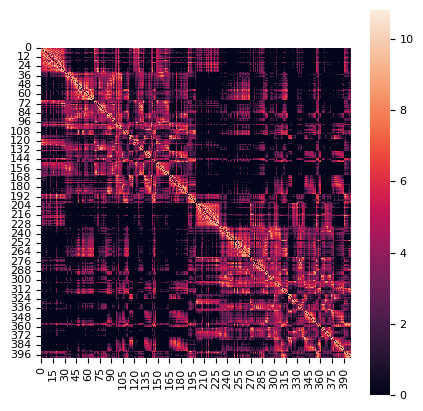

In [20]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(Am, ax=ax, square=True)
plt.show()

In [21]:
np.count_nonzero(np.triu(Am)) / ((Am.shape[0] ** 2 - Am.shape[0]) / 2)

0.5230325814536341

In [22]:
print(np.any(Am < 0))
print(np.any(np.isinf(Am)))
print(np.any(np.isnan(Am)))

False
False
False


## Save

In [23]:
outdir = '/home/lindenmp/research_projects/nct_xr/data/int_deflections'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [24]:
# save
file_str = os.path.join(outdir, 'HCP-D_{0}_A.npy'.format(atlas))
np.save(file_str, A)
file_str = os.path.join(outdir, 'HCP-D_{0}_Am.npy'.format(atlas))
np.save(file_str, Am)
file_str = os.path.join(outdir, 'HCP-D_{0}_myelin.npy'.format(atlas))
np.save(file_str, myelin)
file_str = os.path.join(outdir, 'HCP-D_{0}_rsts.npy'.format(atlas))
np.save(file_str, rsts)
# file_str = os.path.join(outdir, 'HCP-D_{0}_taskts.npy'.format(atlas))
# np.save(file_str, taskts)
for scan in taskts_dict.keys():
    file_str = os.path.join(outdir, 'HCP-D_{0}_taskts-{1}.npy'.format(atlas, scan))
    np.save(file_str, taskts_dict[scan])

In [25]:
file_str = os.path.join(outdir, 'HCP-D_{0}_subjids.txt'.format(atlas))
subject_ids_filt = np.asarray(subject_ids)[~subject_filter]
np.savetxt(file_str, subject_ids_filt, fmt='%s')